<a href="https://colab.research.google.com/github/ZerXXX0/sales-prediction/blob/main/MLQ_KMEANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Load data
train_df = pd.read_csv('https://raw.githubusercontent.com/ZerXXX0/sales-prediction/refs/heads/main/dataset/train_final.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/ZerXXX0/sales-prediction/refs/heads/main/dataset/test_final.csv')

# Columns to drop
drop_cols = ['Unnamed: 0', 'TransactionID', 'MemberID']

# Prepare training data
train_df_clean = train_df.drop(columns=drop_cols)
X = train_df_clean.drop(columns=['next_buy'])
y = train_df_clean['next_buy']

# Save column order
train_cols = X.columns.tolist()

# Impute and scale
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


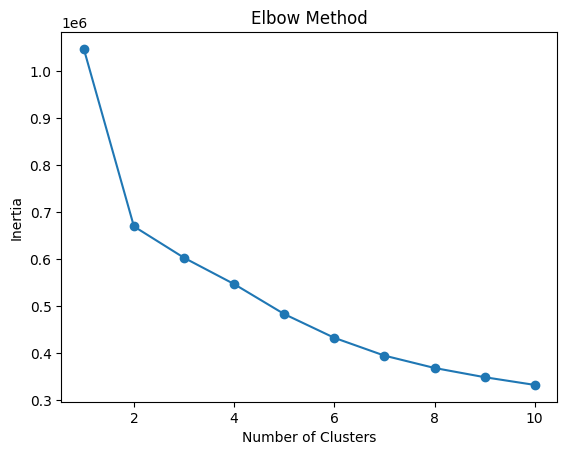

                              TransactionID  cluster
0  ffd6c035bef03a2c386caf2552148fb2402b0b24        0
1  4fadf10aff7e250cc8d63badeaefdf383c0e1c13        1
2  7299df1aaf47b52017f58dd8e59df1fe37072670        1
3  22dae0e1e8bb87601eabd712721bd249739bc620        0
4  6a744d5d79e09b0c1646e604db1c4ec65eff73d7        0


In [3]:
# prompt: i want to use k means clustering

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to find optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10) # Explicitly set n_init
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Assuming the elbow suggests k=2 (visual inspection from the plot)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Explicitly set n_init
kmeans.fit(X_scaled)

# Add cluster labels to the original dataframe
train_df['cluster'] = kmeans.labels_

print(train_df[['TransactionID', 'cluster']].head())

In [4]:
# Preprocess test set
test_df_clean = test_df.drop(columns=drop_cols)
test_df_clean = test_df_clean[train_cols]  # reorder columns

X_test_imputed = imputer.transform(test_df_clean)
X_test_scaled = scaler.transform(X_test_imputed)

# Predict
test_preds = kmeans.predict(X_test_scaled)

# Prepare final submission
submission = pd.DataFrame({
    "MemberID": test_df["MemberID"],
    "next_buy": test_preds
})
submission.to_csv("kmeans_submission.csv", index=False)

In [5]:
submission_df = pd.read_csv("kmeans_submission.csv")
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21098 entries, 0 to 21097
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MemberID  21098 non-null  object
 1   next_buy  21098 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.8+ KB


In [6]:
submit_df = pd.read_csv("https://raw.githubusercontent.com/ZerXXX0/sales-prediction/refs/heads/main/dataset/sample_submission.csv")
# First, create a new dataframe from submission_df with duplicate MemberIDs removed.
# We keep the 'last' entry for each member.
submission_df_unique = submission_df.drop_duplicates(subset=['MemberID'], keep='last')

# Now, create the lookup map from this de-duplicated dataframe.
# This will succeed because the 'MemberID' index is now unique.
next_buy_lookup = submission_df_unique.set_index('MemberID')['next_buy']

# Proceed with the map operation as before. This will now work correctly.
submit_df['next_buy'] = submit_df['MemberID'].map(next_buy_lookup)

submit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6381 entries, 0 to 6380
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MemberID  6381 non-null   object
 1   next_buy  6381 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.8+ KB


In [7]:
submit_df.to_csv('submission_kmeans.csv', index=False)